In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import math
import matplotlib.pyplot as plt

In [7]:
def Backtest(start_year,end_year,indicator,n):

    # file import path
    path = r"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\Fundamental Data 2001-21 Yearly JC.xlsx"
    
    # file export path
    path_to = fr"C:\Users\admin\Dropbox\Purnanand\PMS\Fundamental Analysis\Main Files\Outputs\{start_year}{end_year}{indicator}{n}.xlsx"


    capital           = 1000000
    compunded_capital = capital
    initial_capital   = capital

    # creating blank dataframes for later processes
    change = pd.DataFrame()
    cv_change = pd.DataFrame({"Year":[start_year-1],"CV":[initial_capital]})
    
    for year in range(start_year,end_year+1):
        
        # reading current year and next year file
        df = pd.read_excel(path, sheet_name=str(year))
        df_next = pd.read_excel(path, sheet_name=str(year+1))

        # conditions
        conditions = ["Shareholder's Funds", "PAT", "PBIT"]
        
        # duplicating dataframe
        df1 = df.copy()

        for condition in conditions :
            df1 = df1[df1.fillna(0)[condition]>0]

        # Market Cap >= 100
        df1 = df1[df1['Market Cap']>=100]
        df1 = df1[df1.fillna(0)['Close_July'] != 0]

        # Assigning variables
        pbit = df1['PBIT'].fillna(0)
        pat  = df1["PAT"].fillna(0)
        sf   = df1["Shareholder's Funds"].fillna(0)
        ltb  = df1["Long Term Borrowings"].fillna(0)
        stb  = df1["Short Term Borrowings"].fillna(0)

        # Indicator Calculation

        if indicator == "ROCE":
            df1 = df1[~df1['Name'].str.contains('Bank')]              #  Remove Banking stocks in ROCE
            df1[indicator] = (pbit / (sf + ltb + stb))*100          


        elif indicator == "ROE" :
            df1[indicator] = (pat / sf )*100


        # making another dataFrame to keep just : Name, Indiactor, Close Prices
        df2 = df1[['Name',indicator,'Close_July']].sort_values(by=[indicator],ascending=False)
        df2.rename(columns={'Close_July':"Close1"}, inplace=True)

        df2.reset_index(drop=True, inplace=True)

        
        # adding the Close prices of the Stocks for Next year    
        df2["Close2"] = np.nan

        for i in range(df2.shape[0]):
            try:
                df2["Close2"].iloc[i] = df_next[df_next['Name']==df2['Name'].iloc[i]]['Close_July'].values[0]
            except:
                continue



    #       Quantity
        df2['Qty'] = capital/(n*df2["Close1"] )

        def Floor(x):
            try:
                return math.floor(x)
            except:
                return(x)

    #        Rounded Quantity  
        df2['Qty'] = df2['Qty'].apply(Floor)

    #       Buying price
        df2['Buy'] = df2['Qty']*df2["Close1"]

    #       Selling Price
        df2['Sell'] = df2['Qty']*df2["Close2"]

    #       Dates
        df2['Buy Date'] = f"{year}/07/01"

        df2['Sell date'] = f"{year+1}/07/01"
    #       Perecntage Change
        df2['% Change'] = (df2['Sell']/df2['Buy'] - 1)*100

        df2.reset_index(drop=True, inplace=True)

    #       Result
        result = pd.DataFrame({"Initial Investment":[df2['Buy'][:n].sum()],"Amount at the end of next year":[df2['Sell'][:n].sum()],"% Percentage Return":[100 * (df2['Sell'][:n].sum() / df2['Buy'][:n].sum() - 1)]})

        change = change.append(df2[:n])
        cv_change = cv_change.append(pd.DataFrame({"Year":[year],"CV":[df2['Sell'][:n].sum()]}))

        #display(df2[:n])
        #display(result)

        compunded_capital = compunded_capital*(1+(df2['Sell'][:n].sum() / df2['Buy'][:n].sum() - 1))
        capital = df2['Sell'][:n].sum()

    display(change)

    overall_inv = pd.DataFrame({"Initial Investment":[1000000],"Compunded Amount":[int(compunded_capital)]})


    winners  = change[change['% Change']>0].shape[0]
    losers   = change[change['% Change']<0].shape[0]
    win_per  = change[change['% Change']>0]['% Change'].mean()
    loss_per = change[change['% Change']<0]['% Change'].mean()


    print("\nTop Winners")
    win = change.sort_values(by='% Change',ascending=False)[['Name','% Change']][:20]
    win.reset_index(drop=True, inplace=True)
    display(win)


    print("\nTop Losers")
    lose = change.sort_values(by='% Change',ascending=True)[['Name','% Change']][:20]
    lose.reset_index(drop=True, inplace=True)
    display(lose)


    cv_change['MDD'] = (cv_change['CV']/cv_change['CV'].rolling(len(cv_change),1).max())-1
    calc = pd.DataFrame({"CAGR":[((int(compunded_capital)/initial_capital)**(1/(end_year-start_year+1)) - 1)*100 ],  "Trading Edge":[(winners*win_per)+(losers*loss_per)], "MDD":[min(cv_change['MDD'])*100]})

    display(calc)

    plt.figure(figsize=(15,10))
    plt.plot(cv_change["Year"],cv_change["CV"])
    plt.title("Portfolio Value", fontsize=20)
    plt.show()

    #display(Movers)

    change.to_excel(path_to,sheet_name="Trade File")
    with pd.ExcelWriter(path_to,engine='openpyxl', mode='a',if_sheet_exists='replace') as writer :
        win.to_excel(writer,sheet_name="Winners",index=False)
        lose.to_excel(writer,sheet_name="Loosers",index=False)
        calc.to_excel(writer,sheet_name="Calculations",index=False)


    print()

,Name,ROCE,Close1,Close2,Qty,Buy,Sell,Buy Date,Sell date,% Change
0,Colgate-Palmolive (India) Ltd.,135.786311,501.725000,589.575000,66,33113.850000,38911.950000,2010/07/01,2011/07/01,17.509592
1,Nestle India Ltd.,133.991825,4305.400000,4536.750000,7,30137.800000,31757.250000,2010/07/01,2011/07/01,5.373484
2,Castrol India Ltd.,133.741644,135.875000,134.925000,245,33289.375000,33056.625000,2010/07/01,2011/07/01,-0.699172
3,Piramal Enterprises Ltd.,131.372385,382.504789,508.275741,87,33277.916649,44219.989458,2010/07/01,2011/07/01,32.880883
4,Hindustan Unilever Ltd.,108.152617,336.750000,446.600000,98,33001.500000,43766.800000,2010/07/01,2011/07/01,32.620638
...,...,...,...,...,...,...,...,...,...,...
25,Ajanta Soya Ltd.,51.640576,22.840000,38.720000,4818,110043.120000,186552.960000,2020/07/01,2021/07/01,69.527145
26,Accelya Solutions India Ltd.,51.432350,1185.100000,928.000000,92,109029.200000,85376.000000,2020/07/01,2021/07/01,-21.694372
27,TAAL Enterprises Ltd.,51.384390,639.650000,1631.250000,172,110019.800000,280575.000000,2020/07/01,2021/07/01,155.022278
28,Tata Consultancy Services Ltd.,51.365798,3341.500000,3739.950000,32,106928.000000,119678.400000,2020/07/01,2021/07/01,11.924286



Top Winners


,Name,% Change
0,Alkyl Amines Chemicals Ltd.,327.409117
1,Mayur Uniquoters Ltd.,252.545496
2,RHI Magnesita India Ltd.,251.782364
3,Tata Metaliks Ltd.,234.551657
4,MPS Ltd.,233.625461
5,Ashapura Minechem Ltd.,230.021598
6,Indiamart Intermesh Ltd.,223.082839
7,Sonata Software Ltd.,216.624738
8,NIIT Ltd.,214.185165
9,New Delhi Television Ltd.,212.887664



Top Losers


,Name,% Change
0,Fourth Dimension Solutions Ltd.,-87.315876
1,Eon Electric Ltd.,-71.731009
2,Suumaya Industries Ltd.,-69.735500
3,Viaan Industries Ltd.,-68.011696
4,Paul Merchants Ltd.,-64.277053
5,Websol Energy System Ltd.,-60.437294
6,Adroit Infotech Ltd.,-59.446254
7,Kushal Ltd.,-59.228731
8,HEG Ltd.,-57.921461
9,KSE Ltd.,-57.912746


,CAGR,Trading Edge,MDD
0,14.016831,5962.467327,-31.1236


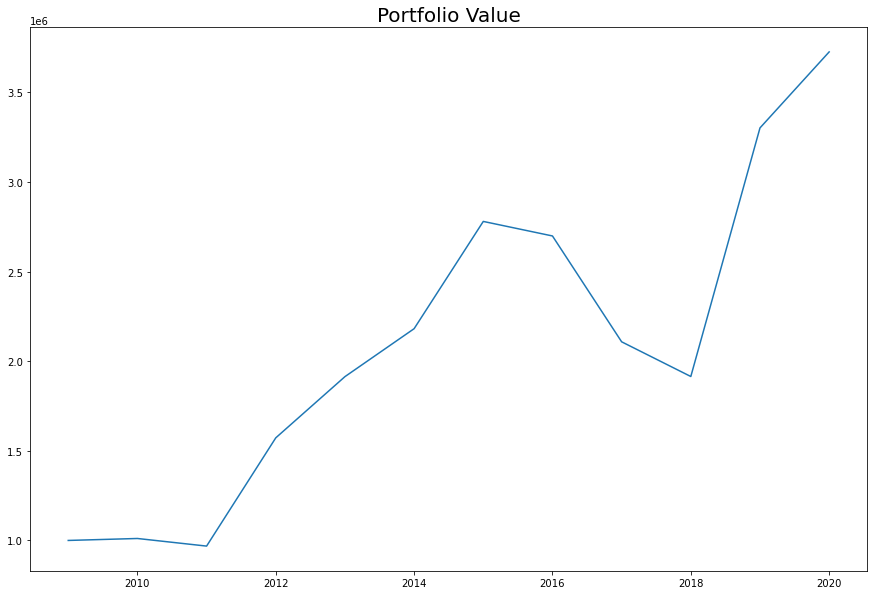

In [8]:
Backtest(2010,2020,"ROCE",30)